In [1]:
import os
import pandas as pd
def load(path): 
    target = []
    list_dir = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            diri = os.path.join(dirname, filename)
            list_dir.append(diri)
            target.append(1)
    print("mission completed!! upload   " + str(len(target))+ '  file')
    data = pd.DataFrame({"target":target,"path": list_dir}) 
    return data

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    load("../input/architecture-dataset"),
    x_col='path',
    y_col='target',
    target_size=(256, 256),
    batch_size=9588//4,
    shuffle=True,
    class_mode="raw")

mission completed!! upload   9598  file
Found 9588 validated image filenames.


In [3]:
import tensorflow.keras as keras
import tensorflow as tf

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [37]:
codings_size = 100
inputs = keras.layers.Input(shape=[256, 256,3])

z = keras.layers.Conv2D(
                filters=32, kernel_size=(3,3), strides=(2, 2), activation='relu')(inputs)
z = keras.layers.Conv2D(
                filters=64, kernel_size=(3,3), strides=(2, 2), activation='relu')(z)
z = keras.layers.Conv2D(
                filters=128, kernel_size=(3,3), strides=(2, 2), activation='relu')(z)
z = keras.layers.Conv2D(
                filters=256, kernel_size=(3,3), strides=(2, 2), activation='relu')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(codings_size)(z) # μ
codings_log_var = keras.layers.Dense(codings_size)(z) # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(
 inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [38]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(units=4*4*32, activation="relu")(decoder_inputs)
x = keras.layers.Reshape(target_shape=(4, 4, 32))(x)
x = keras.layers.Conv2DTranspose(
                filters=64*4, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=64*2, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=64, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=64//2, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=64//4, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=64//8, kernel_size=(3,3), strides=2, padding='same',
                activation='relu')(x)
x = keras.layers.Conv2DTranspose(
                filters=3, kernel_size=(3,3), strides=1, padding='same',activation="sigmoid")(x)
outputs = keras.layers.Reshape([256,256,3],input_shape=[256,256,3])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [39]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [40]:
import numpy as np
latent_loss = -0.5 * tf.math.reduce_sum(
 1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
 axis=-1)
variational_ae.add_loss(tf.math.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [24]:
import torch 
torch.cuda.get_device_name()


'Tesla P100-PCIE-16GB'

In [ ]:
history = variational_ae.fit(test_generator[1][0], test_generator[1][0], epochs=20, batch_size=64)

In [44]:
codings = tf.random.normal(shape=[10, codings_size])
images = variational_decoder(codings).numpy()

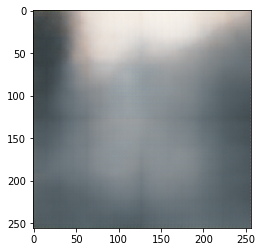

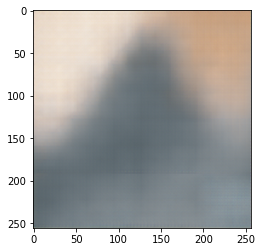

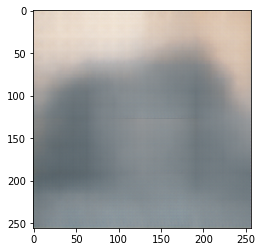

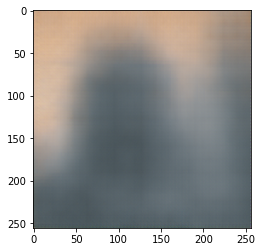

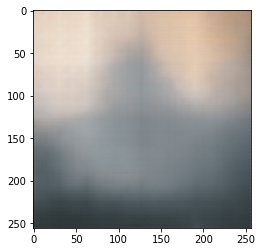

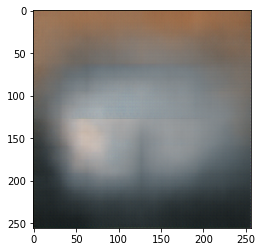

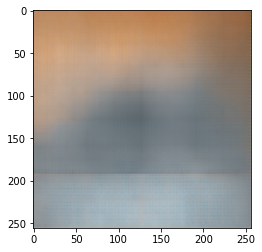

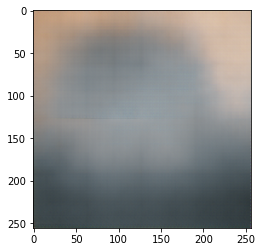

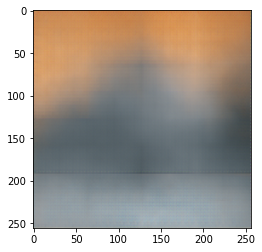

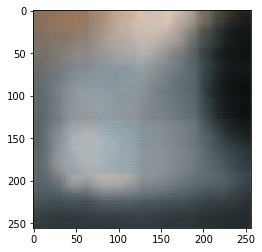

In [47]:
import cv2
import matplotlib.pyplot as plt
p = 0
for i in images:
    plt.figure()
    plt.imshow(cv2.cvtColor(np.reshape(i,(256,256,3)),cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(p + 1) +".jpg",np.reshape(i,(256,256,3)))
    